# Open Program - Capsule Networks
This notebook explains how Capsule Networks work and can be applied.

## 0. Preparation
In this section useful libraries are imported which are used in most data science projects.

In [1]:
import os
import sys
import datetime

# sets the path to the home directory of this repository so other modules can be imported. 
project_path = os.getcwd()
root_path = os.path.split(os.path.split(os.getcwd())[0])[0]
assert root_path.endswith("Fontys-ADS"), "The root path does not end with Fontys-ADS: " + root_path 
sys.path.insert(0, root_path)

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# for easily displaying images
from IPython.display import Image

# set the seed for reproducible results.
np.random.seed(56)
tf.random.set_seed(56)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print("Tensorflow version: " + tf.version.VERSION)

Tensorflow version: 2.3.0


## 1. What are Capsule Neural Networks?
d

## 2. Implementation
In this notebook, the proposed architecture from the paper [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829) for solving MNIST is implemented. <br>
The task of classifying the handwritten digits from the MNIST dataset is often used as a benchmark for machine learning algorithms.<br>
![Capsule Network MNIST](https://github.com/metalglove/Fontys-ADS/blob/master/Assignments/OP/Capsule-network-mnist-main.jpg?raw=true) <br>
Figure 1. Capsule Network MNIST.<br>
As seen in figure 1, the architecture has 2 new components in model building. <br>
A PrimaryCaps layer and a DigitCaps layer. But, there are also 2 new techniques that can not be seen here, <br>
they are called a squash activation function and a routing algorithm for agreement. <br>
In the following chapters these layers and techniques will be implemented and explained.

### 2.1 MNIST dataset
The MNIST dataset is widely used dataset in the field of machine learning and image processing. <br>
The TFDS (TensorFlow Datasets) library provides a collection of ready-to-use datasets for use with <br>
TensorFlow and other machine learning frameworks, including the [MNIST](https://www.tensorflow.org/datasets/catalog/mnist) dataset. <br>


In [2]:
import tensorflow_datasets as tfds
from datasets.base_image_dataset import ImageDatasetBase

class MNISTDataset(ImageDatasetBase):
    def __init__(self, batch_size, train_percentage, validation_percentage, test_percentage):
        super(MNISTDataset, self).__init__(batch_size, 28, 28)
        self.batch_size = batch_size
        
        # gets the initial data from MNIST using the TFDS API.
        self.data = tfds.load('mnist', split='train+test', as_supervised=True)
        
        # fix the datatypes and hot encode y.
        self.data = self.data.map(self.fix, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # shuffles the dataset
        self.shuffle(256)

        # splits the data into train, validation, and test datasets.
        self.split_data_to_train_val_test(self.data, train_percentage, validation_percentage, test_percentage)
    
    def fix(self, x, y):
        x = tf.image.resize(x, [self.img_height, self.img_width])
        x = tf.image.convert_image_dtype(x, tf.float32)
        y = tf.one_hot(y, 10)
        return x, y

### 2.2 Squashing Activation Function
The squashing activation function is a non-linear activation function used with capsule layers.<br>
The length of the output vector of a capsule represents the probability that the entity <br>
represented by the capsule is present in the current input. A non-linear ``squashing`` <br>
function is used to ensure that short vectors get shrunk to almost zero length and long vectors get shrunk to a <br>
length slightly below 1. <br> <br>
 In the paper it is stated that they leave it to discriminative learning to make good use of this non-linearity. <br>

\begin{multline*}
    {\bf v}_j = \frac{||{\bf s}_j||^2}{1+||{\bf s}_j||^2} \frac{{\bf s}_j}{||{\bf s}_j||}
\end{multline*}
where ${\bf v}_j$ is the vector output of capsule $j$ and ${\bf s}_j$ is its total input. <br> 
<br>
However, according to Aurélien Géron in the youtube video [How to implement CapsNets using TensorFlow](https://youtu.be/2Kawrd5szHE), <br>
when using the `tf.norm` function and if one of the vectors is zero, the gradients of the model will <br>
turn to `NaN`s. The model would effectively be dead. This is prevented by creating a safer approxamation of the norm. <br>
\begin{multline*}
    {||{\bf s}_j||} \approx \sqrt{\sum_j {s_j}^2 + \epsilon} 
\end{multline*}
where ${\bf{\epsilon}}$ is ${1_e - 07}$ (from `tf.keras.epsilon()`).

In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class SquashActivationLayer(Layer):
    def __init__(self):
        super(SquashActivationLayer, self).__init__()
        # ---------------------------- Squash Activation Layer ----------------------------

    def call(self, vectors, axis=-1):
        # ---------------- Original interpretation of the squash function -----------------
        # An epsilon is added to prevent division by zero errors.
        # norm = tf.norm(vectors, axis=axis, keepdims=True) + K.epsilon()
        # squared_norm = tf.square(norm)
        # scaling = vectors / norm
        # squash_factor = squared_norm / (1 + squared_norm)
        # return squash_factor * scaling
        # ----------------- Safer implementation of the squash function -------------------
        squared_norm = tf.reduce_sum(tf.square(vectors), axis=axis, keepdims=True)
        safe_norm = tf.sqrt(squared_norm + K.epsilon())
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = vectors / safe_norm
        return squash_factor * unit_vector

### 2.3 Primary Capsule Layer
The primary capsules are the lowest level of multi-dimensional entities and, from an inverse graphics <br>
perspective, activating the primary capsules corresponds to inverting the rendering process. <br>
This is a very different type of computation than piecing instantiated parts together to make familiar wholes, <br>
which is what capsules are designed to be good at. <br>
<br>
The primary capsule layer is a convolutional capsule layer with 32 channels of convolutional <br>
8D capsules (i.e. each primary capsule contains 8 convolutional units with a 9 × 9 kernel and a stride of 2). <br>
Each primary capsule output sees the outputs of all 256 × 81 Conv1 units whose receptive fields overlap with <br>
the location of the center of the capsule. In total the PrimaryCapsules have 32 × 6 × 6 capsule outputs <br> 
(each output is an 8D vector) and each capsule in the 6 × 6 grid is sharing their weights with each other. <br>
<br>
One can see the primary capsule layer as a convolution layer using the ``squashing`` function as block non-linearity. 

In [4]:
from tensorflow.keras.layers import Conv2D, Reshape, Input

class PrimaryCapsuleLayer(Layer):
    def __init__(self, channels, capsule_dimension, kernel_size, strides):
        super(PrimaryCapsuleLayer, self).__init__()
        # ---------------------------- Primary Capsule Layer ----------------------------

        self.channels = channels
        self.capsule_dimension = capsule_dimension
        self.kernel_size = kernel_size
        self.strides = strides

        # 1. convolutional layer.
        capsule_filters = capsule_dimension * channels
        self.conv1_layer = Conv2D(filters=capsule_filters, kernel_size=kernel_size, strides=strides, padding='valid')
        
        # 2. reshape layer for 1D capsule outputs.
        self.reshape_layer = Reshape(target_shape=(-1, capsule_dimension))

        # 3. squashing outputs.
        self.squash_activation_layer = SquashActivationLayer()

    def call(self, inputs):
        x = self.conv1_layer(inputs)
        x = self.reshape_layer(x)
        x = self.squash_activation_layer(x)
        return x

    def compute_output_shape(self, input_shape):
        return tuple([None, self.channels, 1, self.capsule_input_number])

    def get_config(self):
        config = {
            'channels': self.channels,
            'capsule_dimension': self.capsule_dimension,
            'kernel_size': self.kernel_size,
            'strides': self.strides
        }
        base_config = super(PrimaryCapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### 2.4 Routing Algorithm
For all but the first layer of capsules, the total input to a capsule ${\bf s}_j$ is a weighted sum over all ``prediction vectors`` ${\bf \hat{u}}_{j|i}$ <br>
from the capsules in the layer below and is produced by multiplying the output  ${\bf u}_i$ of a capsule in the layer below by a weight matrix  ${\bf W}_{ij}$ <br>
where the $c_{ij}$ are coupling coefficients that are determined by the iterative dynamic routing process. <br>
The coupling coefficients between capsule $i$ and all the capsules in the layer above sum to $1$ and are determined by a ``routing softmax`` <br>
whose initial logits $b_{ij}$ are the log prior probabilities that capsule~$i$ should be coupled to capsule~$j$. <br>
\begin{multline*}
    {\bf \hat{u}}_{j|i} = {\bf W}_{ij}{\bf u}_i 
\end{multline*}

\begin{multline*}
    c_{ij} = \frac{\exp(b_{ij})}{\sum_k \exp(b_{ik})}
\end{multline*}

\begin{multline*}
    {\bf s}_j = \sum_i c_{ij} {\bf \hat{u}}_{j|i}
\end{multline*}
The log priors can be learned discriminatively at the same time as all the other weights. <br>
They depend on the location and type of the two capsules but not on the current input image. <br>
The initial coupling coefficients are then iteratively refined by measuring the agreement between <br>
the current output ${\bf v}_j$ of each capsule, $j$, in the layer above and the prediction ${\bf \hat{u}}_{j|i}$ made by capsule $i$. 

The agreement $a_{ij}$ is simply the scalar product. <br>
\begin{multline*}
    a_{ij} = {\bf v}_j \cdot {\bf \hat{ u}}_{j|i}
\end{multline*}
This agreement is treated as if it was a log likelihood and is added to the initial logit, $b_{ij}$ before computing <br> 
the new values for all the coupling coefficients linking capsule~$i$ to higher level capsules. <br>
![Routing algorithm](https://github.com/metalglove/Fontys-ADS/blob/master/Assignments/OP/Routing%20algorithm.png?raw=true) <br>
Figure 2. Routing algorithm.

In [5]:
class Routing(Layer):
    def __init__(self, batch_size, channels, number_of_capsules, routings):
        super(Routing, self).__init__()
        # -------------------------- Routing algorithm --------------------------
        self.batch_size = batch_size
        self.channels = channels
        self.number_of_capsules = number_of_capsules
        self.routings = routings

        self.squash_activation_layer = SquashActivationLayer()

    def call(self, u_hat_ji):
        # initialise "log prior probabilities" coupling coefficients as zero.
        bi = tf.zeros(shape=(self.batch_size, self.channels, 1, self.number_of_capsules))
        # iterate routings.
        for r in range(self.routings):
            # normalise coupling coefficients (logits) by softmax.
            ci = tf.nn.softmax(bi, axis=1)
            # multiply normalised coupling coefficients by predicted inputs.
            sj = tf.matmul(ci, u_hat_ji)
            # squash capsule j's coupling coefficient.
            vj = self.squash_activation_layer(sj)
            # update the coupling coefficients for next iteration of routing algorithm.
            if r < self.routings - 1:
                # update the total sum of coupling coefficients (routing agreement).
                bi += tf.matmul(vj, u_hat_ji, transpose_b=True)
        return vj

    def compute_output_shape(self, input_shape):
        return tuple([self.batch_size, self.channels, 1, self.number_of_capsules])

    def get_config(self):
        config = {
            'channels': self.channels,
            'capsule_dimension': self.capsule_dimension,
            'number_of_capsules': self.number_of_capsules,
            'routings': self.routings
        }
        base_config = super(Routing, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### 2.5 Dense Capsule Layer
The capsule layer functions much like a normal dense layer albeit with more dimensions. <br>
The weights of the capsule layer function as a transformation matrix, <br> 
where a weight is stored for each capsule pair (i, j) from the layer before (i) <br>
and the current layer (j) with their respective dimensions. <br>
To compute the predicted output vectors for each capsule (${\bf u}_i$), the input is tiled to the <br>
number of output capsules in the capsule layer (j) and multiplied with the weights (${\bf W}_{ij}$). <br>
<br>
In convolutional capsule layers, each capsule outputs a local grid of vectors to each type of capsule in <br>
the layer above using different transformation matrices for each member of the grid as well as for each type of capsule.


In [6]:
from tensorflow.keras import initializers

class DenseCapsuleLayer(Layer):
    def __init__(self, channels, capsule_dimension, routings, kernel_initializer='glorot_uniform'):
        super(DenseCapsuleLayer, self).__init__()
        # ---------------------------- Dense Capsule Layer ----------------------------
        self.channels = channels
        self.capsule_dimension = capsule_dimension
        self.routings = routings
        self.initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        self.number_of_capsules = input_shape[1]
        self.capsule_input_dimension = input_shape[2]
        weight_shape = (self.channels, self.number_of_capsules, self.capsule_dimension, self.capsule_input_dimension)
        # transformation matrix containing a weight for each capsule pair (i, j).
        self.Wij = self.add_weight(shape=weight_shape, initializer=self.initializer, name='W')
        # batch size is determined during training time (depicted by None in shape of tensor).
        batch_size = input_shape[0]
        self.routing = Routing(batch_size, self.channels, self.number_of_capsules, self.routings)
        self.built = True

    def call(self, ui):
        # shape of ui = [None, number_of_capsules, capsule_input_dimension]
        
        # prepares the inputs to be tiled.
        # MNIST example: 
        # - primary capsules = 1152 (6 x 6 x 32) 
        # - capsule dimension = 8
        # - None is the batch size
        # - ui = [None, 1152, 8]
        # - expanded_ui = [None, 1, 1152, 8, 1]
        expanded_ui = tf.expand_dims(tf.expand_dims(ui, 1), -1)

        # tiles the inputs by the number of capsules in this layer.
        # MNIST example:
        # - channels = 10 (10 digits)
        # - expanded_ui = [None, 1, 1152, 8, 1]
        # - ui_tiled_by_channels = [None, 10, 1152, 8, 1]
        ui_tiled_by_channels = tf.tile(expanded_ui, [1, self.channels, 1, 1, 1])

        # performs 4D array multiplication to get the predicted output vectors.
        # by using the map_fn function, mapping the matmul by the tiled channels, the performance increases 2x 
        # instead of: u_hat_ji = tf.matmul(self.Wij, ui_tiled_by_channels).
        # MNIST example:
        # - shape of Wij = [self.channels, self.number_of_capsules, self.capsule_dimension, self.capsule_input_dimension]
        # - Wij = [10, 1152, 16, 8]
        # - ui_tiled_by_channels = [None, 10, 1152, 8, 1]
        # - ui_tiled = [None, 1, 1152, 8, 1]
        # - u_hat_ji = [None, 10, 1152, 16, 1]
        u_hat_ji = tf.map_fn(lambda ui_tiled: tf.matmul(self.Wij, ui_tiled), elems=ui_tiled_by_channels)
        
        # removes the last dimension from the predicted output vectors.
        u_hat_ji = tf.squeeze(u_hat_ji, axis=4)

        # performs routing algorithm by agreement on predicted output vectors.
        aij = self.routing(u_hat_ji)
        return tf.squeeze(aij)
    
    def compute_output_shape(self, input_shape):
        return tuple([None, self.channels, self.capsule_dimension])

    def get_config(self):
        config = {
            'channels': self.channels,
            'capsule_dimension': self.capsule_dimension,
            'routings': self.routings
        }
        base_config = super(DenseCapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### 2.6 Length Layer
The length of the output vectors represents the class probabilities. <br> 
This layer is added to transform the outputs of the last capsule layer to the class probabilities. <br>
\begin{multline*}
    {||{\bf v}_k||} \approx \sqrt{\sum_v {v_k}^2 + \epsilon} 
\end{multline*}
Note that the safe norm is also used here!

In [7]:
class Length(Layer):
    def __init__(self):
        super(Length, self).__init__()
        # ---------------------------- Length Layer ----------------------------

    def call(self, inputs):
        squared_norm = tf.reduce_sum(tf.square(inputs), axis=-1)
        safe_norm = tf.sqrt(squared_norm + K.epsilon())
        return safe_norm

    def compute_output_shape(self, input_shape):
        # the last dimension is the output shape.
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config

### 2.7 MNIST Capsule Network
The MNIST capsule network starts with a convolutional layer having 256 filters, a <br>
kernel size of 9,  strides of 1 and using the ReLU activation function. <br>
This layer is used to convert the pixel intensities to the activities of local feature detectors <br>
that are then used as inputs to the primary capsules. The following layer is the <br>
primary capsule layer having 32 capsules, a capsule dimension of 8, <br>
a kernel size of 9 and strides of 2. Then, the dense capsule layer (digit capsule layer) is added <br> 
with 10 capsules, a capsule dimension of 16 and a depth of 3 for the routing algorithm. <br> 
Lastly, a length layer is added to transform the outputs of the digit capsule layer to estimated class probabilities.

In [8]:
class MNISTCapsuleNetwork(tf.keras.Model):
    def __init__(self, image_dimensions):
        super(MNISTCapsuleNetwork, self).__init__()
        # ---------------------------- MNIST Capsule Network ----------------------------
        # set image dimensions.
        self.image_height, self.image_width, self.image_channels = image_dimensions

        # MNIST contains 10 classes: 0, 1, 2, 3, 4, 5, 6, 7, 8 and 9.
        self.classes = 10

        # 1. first convolutional layer.
        self.conv1 = Conv2D(filters=256, kernel_size=9, strides=1, activation='relu')

        # 2. primary capsule layer.
        self.primary_capsule_layer = PrimaryCapsuleLayer(channels=32, capsule_dimension=8, kernel_size=9, strides=2)

        # 3. digit capsule layer.
        self.digit_capsule_layer = DenseCapsuleLayer(channels=self.classes, capsule_dimension=16, routings=3)

        # 4. transform digit capsules to class probabilities layer.
        self.transform_to_class_probabilities = Length()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.primary_capsule_layer(x)
        x = self.digit_capsule_layer(x)
        x = self.transform_to_class_probabilities(x)
        return x

### 2.8 Loss function
The loss function used for capsule networks is called the margin loss function. <br>
\begin{multline*}
    L_k = T_k \ \max(0, m^{+} - ||{\bf v}_k||)^2 + \lambda \ (1-T_k) \ \max(0, ||{\bf v}_k|| - m^{-})^2
\end{multline*}
Where the length of the instantiation vector $||{\bf v}_k||$ is used to represent the probability that a <br> 
capsule its entity exists, $m^{+} = 0.9$ and $m^{-} = 0.1$.  <br>
The $\lambda$ is used for down-weighting of the loss for absent classes which stops the initial learning <br>
from shrinking the lengths of the activity vectors of all the output capsules. $\lambda$ is set to 0.5.<br>
The loss will be zero if the output capsule predicts the correct label with greater than 0.9 probability, <br>
and it will be non-zero if the probability is less than 0.9. <br>

<br>
The total loss is simply the sum of the losses from all output capsules.

In [9]:
from tensorflow.keras.losses import Loss

class MarginLoss(Loss):
    def __init__(self, lambda_y = 0.5, m_plus = 0.9, m_minus = 0.1):
        super(MarginLoss, self).__init__()
        self.lambda_y = lambda_y
        self.m_plus = m_plus
        self.m_minus = m_minus

    def call(self, y_true, y_pred):
        correct = y_true * tf.square(tf.maximum(0.0, self.m_plus - y_pred))
        incorrect = self.lambda_y * (1.0 - y_true) * tf.square(tf.maximum(0.0, y_pred - self.m_minus))
        loss = correct + incorrect
        # sum of all losses (each capsule output)
        return tf.reduce_mean(tf.reduce_sum(loss, 1))

# 3. Training
To start the training of the MNIST capsule network, the dataset first needs to be initialised. <br>
The dataset is split into a training (60%), validation (20%) and test (20%) set with a batch size of 100. <br>


In [10]:
batch_size = 100
train_percentage = 0.6
validation_percentage = 0.2
test_percentage = 0.2
mnistDataset = MNISTDataset(batch_size, train_percentage, validation_percentage, test_percentage)

train: 420 validation: 140 test: 140


The MNIST capsule network is then compiled using the Adam optimizer and the margin loss. <br>

In [11]:
from tensorflow.keras.optimizers import Adam

image_dimensions = (mnistDataset.img_height, mnistDataset.img_width, 1)
model = MNISTCapsuleNetwork(image_dimensions)
model.build((batch_size,) + image_dimensions)
model.compile(optimizer=Adam(), loss=MarginLoss(), metrics='accuracy')
model.summary(line_length=137)

Model: "mnist_capsule_network"
_________________________________________________________________________________________________________________________________________
Layer (type)                                                 Output Shape                                           Param #              
conv2d (Conv2D)                                              multiple                                               20992                
_________________________________________________________________________________________________________________________________________
primary_capsule_layer (PrimaryCapsuleLayer)                  multiple                                               5308672              
_________________________________________________________________________________________________________________________________________
dense_capsule_layer (DenseCapsuleLayer)                      multiple                                               1474560              
___

To properly keep track of the model's performance, a TensorBoard callback is used. <br>
Also, an early stopping callback is added to prevent the model training when the loss does not improve. <br>

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# current time
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# create the checkpoint path
checkpoint_path = "checkpoints/mnist_capsnet/" + current_time + ".ckpt"

# create logging
log_dir = "logs/mnist_capsnet/" + current_time

# create all callbacks
callbacks = [
  EarlyStopping(patience=5, monitor='val_loss'),
  TensorBoard(log_dir=log_dir, profile_batch=0),
  ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
]

Afterwards, the MNIST capsule network is trained for 50 epochs or less depending on the early stopping mechanism.

In [13]:
epochs = 50
history = model.fit(
    mnistDataset.train_ds, 
    validation_data=mnistDataset.val_ds, 
    batch_size=batch_size,
    epochs=epochs, 
    validation_steps=mnistDataset.val_size,
    steps_per_epoch=mnistDataset.train_size,
    callbacks=callbacks,
    verbose=1)

Epoch 1/50
420/420 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9299
Epoch 00001: saving model to checkpoints/mnist_capsnet\20201206-210141.ckpt
420/420 [==============================] - 57s 135ms/step - loss: 0.0708 - accuracy: 0.9299 - val_loss: 0.0189 - val_accuracy: 0.9854
Epoch 2/50
420/420 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9905
Epoch 00002: saving model to checkpoints/mnist_capsnet\20201206-210141.ckpt
420/420 [==============================] - 56s 134ms/step - loss: 0.0139 - accuracy: 0.9905 - val_loss: 0.0138 - val_accuracy: 0.9886
Epoch 3/50
420/420 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9948
Epoch 00003: saving model to checkpoints/mnist_capsnet\20201206-210141.ckpt
420/420 [==============================] - 57s 137ms/step - loss: 0.0086 - accuracy: 0.9948 - val_loss: 0.0121 - val_accuracy: 0.9898
Epoch 4/50
420/420 [==============================] - ETA: 0s - loss: 0.0054 - acc

The plots below show the accuracy and loss on the training and validation set.

In [10]:
from matplotlib.ticker import ScalarFormatter

def visualise_results(history, yscale='linear', epoch_start=0):
    def plot_graph(history, metric, yscale, epoch_start):
        plt.plot(history.history[metric])
        plt.plot(history.history['val_'+metric], '')
        plt.xlabel("epochs", fontsize=15)
        plt.ylabel(metric, fontsize=15)
        plt.legend([f'training {metric}', f'validation {metric}'])
        plt.xlim(epoch_start, None)
        plt.yscale(yscale)
        plt.gca().yaxis.set_major_formatter(ScalarFormatter())

    fig = plt.figure(figsize=(16, 8))
    fig.suptitle("Training metrics", fontsize=20)
    
    plt.subplot(1, 2, 1)
    plot_graph(history, 'accuracy', yscale, epoch_start)
    
    plt.subplot(1, 2, 2)
    plot_graph(history, 'loss', yscale, epoch_start)

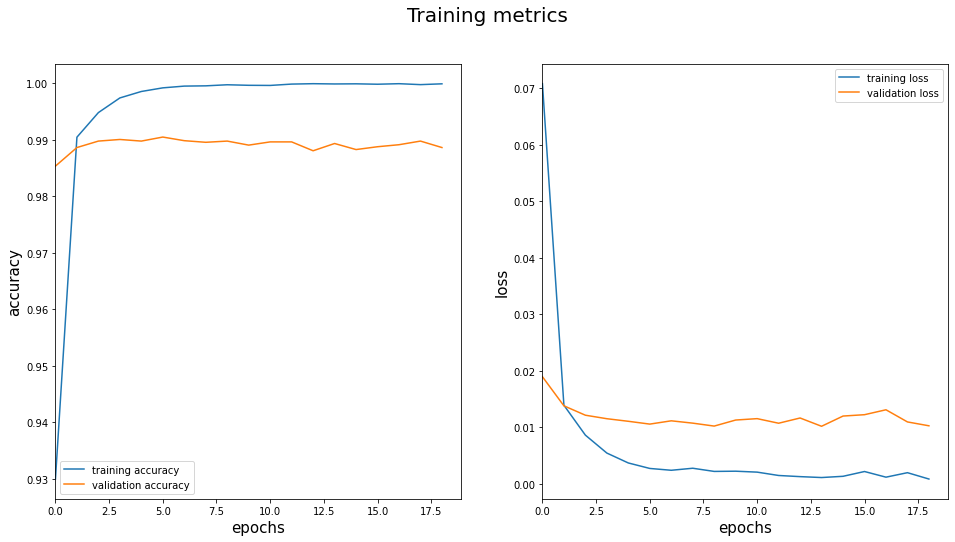

In [14]:
visualise_results(history)

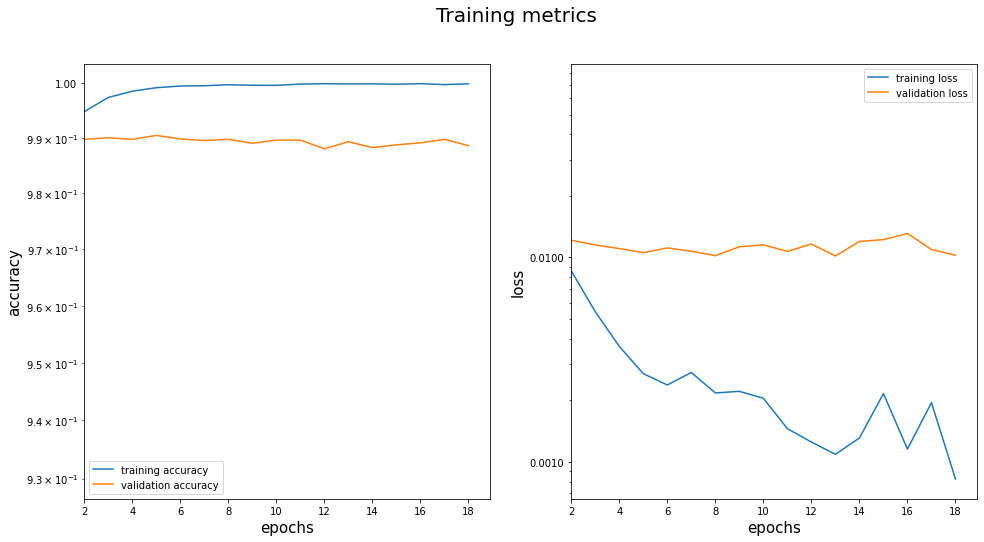

In [15]:
visualise_results(history, yscale='log', epoch_start=2)

After the training is completed, the model is saved to be used again later.

In [16]:
weights_path = 'mnist.h5'

In [17]:
model.save_weights(weights_path)

# 4. Evaluation
The evaluate the performance of the model, the unseen test set is used. <br>
But, first, let's reload the weights of the model.

In [18]:
model.load_weights(weights_path)

The loss and test accuracy are easily found by using the handy evaluate function on the model itself.

In [19]:
result = model.evaluate(mnistDataset.actual_test_ds)
print(f'Test loss: {result[0]:.4f}')
print(f'Test accuracy: {result[1]:.2f}%')

140/140 [==============================] - 5s 36ms/step - loss: 0.0103 - accuracy: 0.9895
Test loss: 0.0103
Test accuracy: 0.99%


To properly use the test set in metric plots, the data needs to be converted<br>
from tensors to numpy arrays. 

In [20]:
X = np.zeros((14000, 28, 28, 1))
y_true = np.zeros((14000, 10))
i = 0
for x, y in mnistDataset.actual_test_ds.unbatch().as_numpy_iterator():
    X[i] = x
    y_true[i] = y
    i += 1

Performs the prediction on the X of the test set to create the y predictions.

In [21]:
y_pred = model.predict(X, verbose=1, batch_size=batch_size, steps=mnistDataset.test_size)

140/140 [==============================] - 5s 36ms/step


A confusion matrix is plotted to present which mistakes the model made.

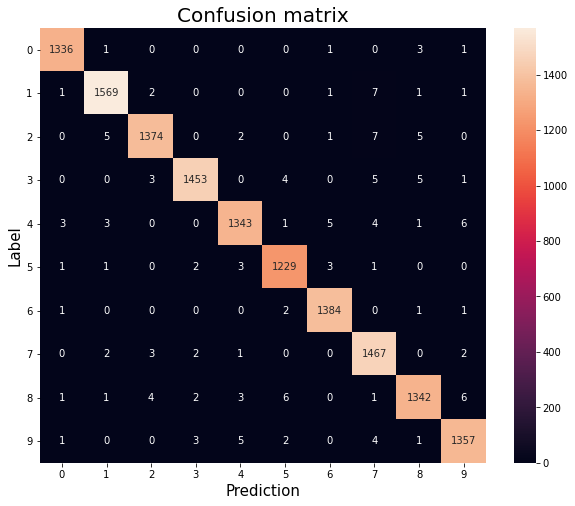

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mtx = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), annot=True, fmt='g')
plt.title("Confusion matrix", fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Label', fontsize=15)
plt.yticks(rotation=0)
plt.show()

# Other research
In the cells below, a different task than MNIST is attempted.<br>
A facemask dataset is used where people are either wearing a facemask correctly or incorrectly.<br>
The task is to predict whether someone is wearing a facemask correctly.<br>

In [11]:
import pathlib

facemaskpath = 'C:/Facemask-dataset/'

class FacemaskDataset(ImageDatasetBase):
    def __init__(self, path, batch_size, train_percentage, validation_percentage, test_percentage):
        super(FacemaskDataset, self).__init__(batch_size, 128, 128)
        self.batch_size = batch_size

        # sets the path to the dataset
        self.path = pathlib.Path(path)

        # creates the initial dataset from a directory containing all the images
        # then mapped to the process_image method to get X, Y
        self.data = tf.data.Dataset\
            .list_files(str(self.path/'**/*'), shuffle=True)\
            .map(self.process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # shuffles the dataset
        self.shuffle(256)

        # splits the data into train, validation, and test datasets.
        self.split_data_to_train_val_test(self.data, train_percentage, validation_percentage, test_percentage)

    def process_image(self, image_path):
        # reads the image from disk as an encoded string
        img = tf.io.read_file(image_path)
        # decodes it to an image.
        img = self.decode_img(img, channels=3)

        def if_true(img, image_path):
            return img, [tf.constant(1, dtype=tf.float32), tf.constant(1, dtype=tf.float32), tf.constant(1, dtype=tf.float32)]

        def if_false(img, image_path):
            chin = tf.cond(tf.strings.regex_full_match(image_path, ".*Chin.*"), lambda: tf.constant(1, dtype=tf.float32), lambda: tf.constant(0, dtype=tf.float32))
            nose = tf.cond(tf.strings.regex_full_match(image_path, ".*Nose.*"), lambda: tf.constant(1, dtype=tf.float32), lambda: tf.constant(0, dtype=tf.float32))
            mouth = tf.cond(tf.strings.regex_full_match(image_path, ".*Mouth.*"), lambda: tf.constant(1, dtype=tf.float32), lambda: tf.constant(0, dtype=tf.float32))
            return img, [chin, mouth, nose]
        
        return img, tf.cond(tf.strings.regex_full_match(image_path, ".*Mask.jpg.*"), lambda: tf.constant(1, dtype=tf.float32), lambda: tf.constant(0, dtype=tf.float32))
        # return tf.cond(tf.strings.regex_full_match(image_path, ".*Mask.jpg.*"), lambda: if_true(img, image_path), lambda: if_false(img, image_path))


In [8]:
batch_size = 100
train_percentage = 0.6
validation_percentage = 0.2
test_percentage = 0.2
facemaskDataset = FacemaskDataset(facemaskpath, batch_size, train_percentage, validation_percentage, test_percentage)

train: 789 validation: 263 test: 263


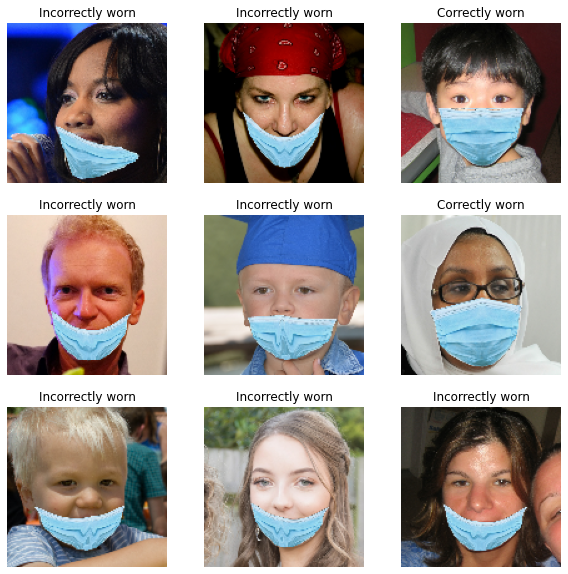

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in facemaskDataset.train_ds.take(1):
  for i in range(9):
    masked = "Incorrectly worn"
    if labels[i]:
        masked = "Correctly worn"
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(masked)
    plt.axis("off")

In [12]:
from tensorflow.keras.layers import Dense

class FacemaskCapsuleNetwork(tf.keras.Model):
    def __init__(self, image_dimensions):
        super(FacemaskCapsuleNetwork, self).__init__()
        # ---------------------------- Facemask Capsule Network ----------------------------
        # set image dimensions.
        self.image_height, self.image_width, self.image_channels = image_dimensions

        # Facemask dataset has 1 class.
        self.classes = 1

        # 1. first convolutional layer.
        self.conv1 = Conv2D(filters=256, kernel_size=9, strides=1, activation='relu')

        # 2. primary capsule layer.
        self.primary_capsule_layer = PrimaryCapsuleLayer(channels=8, capsule_dimension=8, kernel_size=9, strides=2)
        
        # # 3. hidden capsule layer.
        self.facemask_capsule_layer1 = DenseCapsuleLayer(channels=3, capsule_dimension=9, routings=3)
        
        # 4. facemask capsule layer.
        # self.facemask_capsule_layer2 = DenseCapsuleLayer(channels=self.classes, capsule_dimension=32, routings=3)

        # 5. transform facemask capsule to single output with sigmoid.
        self.output_layer = Dense(self.classes, activation='sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.primary_capsule_layer(x)
        x = self.facemask_capsule_layer1(x)
        # x = self.facemask_capsule_layer2(x)
        x = self.output_layer(x)
        return x

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

image_dimensions = (facemaskDataset.img_height, facemaskDataset.img_width, 3)
model = FacemaskCapsuleNetwork(image_dimensions)
model.build((batch_size,) + image_dimensions)
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics='accuracy')
model.summary(line_length=137)

Model: "facemask_capsule_network"
_________________________________________________________________________________________________________________________________________
Layer (type)                                                 Output Shape                                           Param #              
conv2d (Conv2D)                                              multiple                                               62464                
_________________________________________________________________________________________________________________________________________
primary_capsule_layer (PrimaryCapsuleLayer)                  multiple                                               1327168              
_________________________________________________________________________________________________________________________________________
dense_capsule_layer (DenseCapsuleLayer)                      multiple                                               5419008              


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# current time
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# create the checkpoint path
checkpoint_path = "checkpoints/facemask_capsnet/" + current_time + ".ckpt"

# create logging
log_dir = "logs/facemask_capsnet/" + current_time

# create all callbacks
callbacks = [
  EarlyStopping(patience=5, monitor='val_loss'),
  TensorBoard(log_dir=log_dir, profile_batch=0),
  ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
]

In [16]:
epochs = 50
history = model.fit(
    facemaskDataset.train_ds, 
    validation_data=facemaskDataset.val_ds, 
    batch_size=batch_size,
    epochs=epochs, 
    validation_steps=facemaskDataset.val_size,
    steps_per_epoch=facemaskDataset.train_size,
    callbacks=callbacks,
    verbose=1)

Epoch 1/50
789/789 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.8895
Epoch 00001: saving model to checkpoints/facemask_capsnet\20201226-003600.ckpt
789/789 [==============================] - 1170s 1s/step - loss: 0.2525 - accuracy: 0.8895 - val_loss: 0.0837 - val_accuracy: 0.9876
Epoch 2/50
789/789 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9885
Epoch 00002: saving model to checkpoints/facemask_capsnet\20201226-003600.ckpt
789/789 [==============================] - 544s 690ms/step - loss: 0.0658 - accuracy: 0.9885 - val_loss: 0.0448 - val_accuracy: 0.9923
Epoch 3/50
789/789 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9931
Epoch 00003: saving model to checkpoints/facemask_capsnet\20201226-003600.ckpt
789/789 [==============================] - 544s 690ms/step - loss: 0.0370 - accuracy: 0.9931 - val_loss: 0.0276 - val_accuracy: 0.9948
Epoch 4/50
789/789 [==============================] - ETA: 0s - loss: 0.

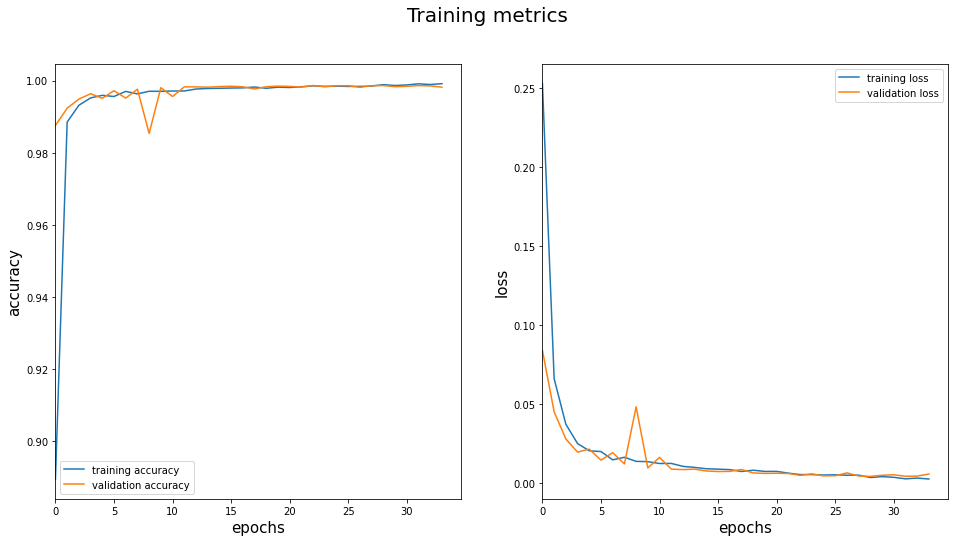

In [17]:
visualise_results(history)

In [18]:
weights_path = 'facemask_caps.h5'

In [19]:
model.save_weights(weights_path)

In [20]:
model.load_weights(weights_path)

In [21]:
test_steps = facemaskDataset.test_size - 1

In [22]:
test_set = facemaskDataset.actual_test_ds.take(test_steps).cache()

In [23]:
def rotate_image(x, y, k):
    x = tf.image.rot90(x, k=k)
    return x, y

def mirror_image(x, y):
    x = tf.image.flip_left_right(x)
    return x, y

def print_result(result):
    print(f'Test loss: {result[0]:.4f}')
    print(f'Test accuracy: {result[1] * 100:.2f}%')

def evaluate_rotations(k):
    result = model.evaluate(test_set.map(lambda x, y: rotate_image(x, y, k), num_parallel_calls=tf.data.experimental.AUTOTUNE), steps=test_steps)
    print_result(result)

def evaluate_mirrored():
    result = model.evaluate(test_set.map(lambda x, y: mirror_image(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE), steps=test_steps)
    print_result(result)

In [24]:
evaluate_rotations(k=0)

262/262 [==============================] - 115s 439ms/step - loss: 0.0062 - accuracy: 0.9983
Test loss: 0.0062
Test accuracy: 99.83%


In [25]:
evaluate_rotations(k=1)

262/262 [==============================] - 44s 168ms/step - loss: 2.2046 - accuracy: 0.4853
Test loss: 2.2046
Test accuracy: 48.53%


In [26]:
evaluate_rotations(k=2)

262/262 [==============================] - 43s 165ms/step - loss: 1.1402 - accuracy: 0.4839
Test loss: 1.1402
Test accuracy: 48.39%


In [27]:
evaluate_rotations(k=3)

262/262 [==============================] - 44s 168ms/step - loss: 2.8331 - accuracy: 0.4953
Test loss: 2.8331
Test accuracy: 49.53%


In [28]:
evaluate_mirrored()

262/262 [==============================] - 43s 165ms/step - loss: 0.0103 - accuracy: 0.9970
Test loss: 0.0103
Test accuracy: 99.70%


In [12]:
from tensorflow.keras.layers import MaxPooling2D, Flatten

class FacemaskCNN(tf.keras.Model):
    def __init__(self, image_dimensions):
        super(FacemaskCNN, self).__init__()
        # ---------------------------- Facemask CNN ----------------------------
        # set image dimensions.
        self.image_height, self.image_width, self.image_channels = image_dimensions

        # Facemask dataset has 1 class.
        self.classes = 1

        self.conv1 = Conv2D(32, 3, activation='relu')
        self.maxpool1 = MaxPooling2D()
        self.conv2 = Conv2D(64, 3, padding='same', activation='relu')
        self.maxpool2 = MaxPooling2D()
        self.conv3 = Conv2D(128, 3, padding='same', activation='relu')
        self.maxpool3 = MaxPooling2D()
        self.flatten = Flatten()
        self.dense1 = Dense(236, activation='relu')
        self.output_layer = Dense(self.classes, activation='sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.output_layer(x)
        return x

In [64]:
from tensorflow.keras.losses import BinaryCrossentropy

model = FacemaskCNN(image_dimensions)
model.build((batch_size,) + image_dimensions)
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics='accuracy')
model.summary(line_length=137)

Model: "facemask_cnn_10"
_________________________________________________________________________________________________________________________________________
Layer (type)                                                 Output Shape                                           Param #              
conv2d_36 (Conv2D)                                           multiple                                               896                  
_________________________________________________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D)                              multiple                                               0                    
_________________________________________________________________________________________________________________________________________
conv2d_37 (Conv2D)                                           multiple                                               18496                
_________

In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# current time
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# create the checkpoint path
checkpoint_path = "checkpoints/facemask_cnn/" + current_time + ".ckpt"

# create logging
log_dir = "logs/facemask_cnn/" + current_time

# create all callbacks
callbacks = [
  EarlyStopping(patience=5, monitor='val_loss'),
  TensorBoard(log_dir=log_dir, profile_batch=0),
  ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
]

In [66]:
epochs = 50
history = model.fit(
    facemaskDataset.train_ds, 
    validation_data=facemaskDataset.val_ds, 
    batch_size=batch_size,
    epochs=epochs, 
    validation_steps=facemaskDataset.val_size,
    steps_per_epoch=facemaskDataset.train_size,
    callbacks=callbacks,
    verbose=1)

Epoch 1/50
789/789 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9860
Epoch 00001: saving model to checkpoints/facemask_cnn\20201225-230556.ckpt
789/789 [==============================] - 707s 896ms/step - loss: 0.0380 - accuracy: 0.9860 - val_loss: 0.0076 - val_accuracy: 0.9973
Epoch 2/50
789/789 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9973
Epoch 00002: saving model to checkpoints/facemask_cnn\20201225-230556.ckpt
789/789 [==============================] - 27s 35ms/step - loss: 0.0076 - accuracy: 0.9973 - val_loss: 0.0046 - val_accuracy: 0.9981
Epoch 3/50
789/789 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9980
Epoch 00003: saving model to checkpoints/facemask_cnn\20201225-230556.ckpt
789/789 [==============================] - 27s 34ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.0067 - val_accuracy: 0.9974
Epoch 4/50
789/789 [==============================] - ETA: 0s - loss: 0.0050 - accurac

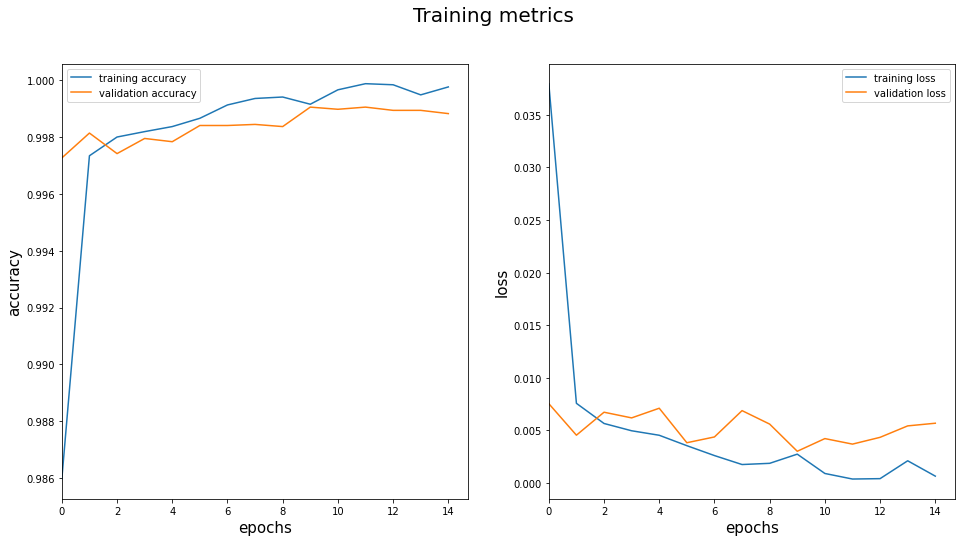

In [67]:
visualise_results(history)

In [68]:
weights_path = 'facemask_cnn.h5'

In [69]:
model.save_weights(weights_path)

In [70]:
model.load_weights(weights_path)

In [71]:
evaluate_rotations(k=0)

262/262 [==============================] - 3s 10ms/step - loss: 0.0065 - accuracy: 0.9987
Test loss: 0.0065
Test accuracy: 99.87%


In [72]:
evaluate_rotations(k=1)

262/262 [==============================] - 5s 18ms/step - loss: 6.0850 - accuracy: 0.4515
Test loss: 6.0850
Test accuracy: 45.15%


In [73]:
evaluate_rotations(k=2)

262/262 [==============================] - 4s 14ms/step - loss: 4.9889 - accuracy: 0.4660
Test loss: 4.9889
Test accuracy: 46.60%


In [74]:
evaluate_rotations(k=3)

262/262 [==============================] - 5s 18ms/step - loss: 5.3515 - accuracy: 0.4734
Test loss: 5.3515
Test accuracy: 47.34%


In [76]:
evaluate_mirrored()

262/262 [==============================] - 4s 14ms/step - loss: 0.0128 - accuracy: 0.9978
Test loss: 0.0128
Test accuracy: 99.78%


In [15]:
flower_path = root_path + '/data/flowers/'

class FlowersDataset(ImageDatasetBase):
    def __init__(self, path, batch_size, train_percentage, validation_percentage, test_percentage):
        super(FlowersDataset, self).__init__(batch_size, 200, 200)
        self.batch_size = batch_size

        # sets the path to the dataset
        self.path = pathlib.Path(path)

        # creates the initial dataset from a directory containing all the images
        # then mapped to the process_image method to get X, Y
        self.data = tf.data.Dataset\
            .list_files(str(self.path/'**/*'), shuffle=True)\
            .map(self.process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # shuffles the dataset
        self.shuffle(256)

        # splits the data into train, validation, and test datasets.
        self.split_data_to_train_val_test(self.data, train_percentage, validation_percentage, test_percentage)

    def process_image(self, image_path):
        # reads the image from disk as an encoded string
        img = tf.io.read_file(image_path)
        # decodes it to an image.
        img = self.decode_img(img, channels=3, is_png=False)

        tulip = tf.cond(tf.strings.regex_full_match(image_path, ".*tulip.*"), lambda: tf.constant(1, dtype=tf.float32), lambda: tf.constant(0, dtype=tf.float32))
        sunflower = tf.cond(tf.strings.regex_full_match(image_path, ".*sunflower.*"), lambda: tf.constant(1, dtype=tf.float32), lambda: tf.constant(0, dtype=tf.float32))
        rose = tf.cond(tf.strings.regex_full_match(image_path, ".*rose.*"), lambda: tf.constant(1, dtype=tf.float32), lambda: tf.constant(0, dtype=tf.float32))
        dandelion = tf.cond(tf.strings.regex_full_match(image_path, ".*dandelion.*"), lambda: tf.constant(1, dtype=tf.float32), lambda: tf.constant(0, dtype=tf.float32))
        daisy = tf.cond(tf.strings.regex_full_match(image_path, ".*daisy.*"), lambda: tf.constant(1, dtype=tf.float32), lambda: tf.constant(0, dtype=tf.float32))
        return img, [tulip, sunflower, rose, dandelion, daisy]

In [16]:
batch_size = 16
train_percentage = 0.6
validation_percentage = 0.2
test_percentage = 0.2
flowersDataset = FlowersDataset(flower_path, batch_size, train_percentage, validation_percentage, test_percentage)

train: 160 validation: 53 test: 53


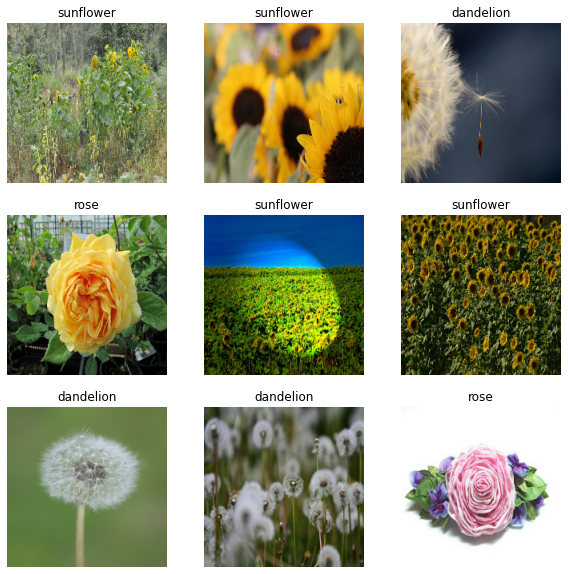

In [18]:
actual_labels = ["tulip", "sunflower", "rose", "dandelion", "daisy"]
plt.figure(figsize=(10, 10))
for images, labels in flowersDataset.train_ds.take(1):
    for i in range(9):
        title = actual_labels[np.argmax(labels[i])]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(title)
        plt.axis("off")

In [120]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

class FlowerCapsuleNetwork(tf.keras.Model):
    def __init__(self, image_dimensions):
        super(FlowerCapsuleNetwork, self).__init__()
        # ---------------------------- FlowerCapsuleNetwork Capsule Network ----------------------------
        # set image dimensions.
        self.image_height, self.image_width, self.image_channels = image_dimensions

        # Facemask dataset has 1 class.
        self.classes = 5

        # 1. first convolutional layer.
        self.conv1 = Conv2D(filters=256, kernel_size=9, strides=1, activation='relu')

        # 2. primary capsule layer.
        self.primary_capsule_layer = PrimaryCapsuleLayer(channels=5, capsule_dimension=6, kernel_size=9, strides=2)

        # 3. flower capsule layer.
        self.flower_capsule_layer = DenseCapsuleLayer(channels=self.classes, capsule_dimension=5, routings=3)
        
        # 4. transform flower capsules to class probabilities layer.
        self.transform_to_class_probabilities = Length()
        # self.transform_to_class_probabilities = Dense(self.classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.primary_capsule_layer(x)
        x = self.flower_capsule_layer(x)
        x = self.transform_to_class_probabilities(x)
        return x

In [121]:
from tensorflow.keras.optimizers import Adam

image_dimensions = (flowersDataset.img_height, flowersDataset.img_width, 3)
model = FlowerCapsuleNetwork(image_dimensions)
model.build((batch_size,) + image_dimensions)
model.compile(optimizer=Adam(), loss=MarginLoss(), metrics='accuracy')
model.summary(line_length=137)

Model: "flower_capsule_network_37"
_________________________________________________________________________________________________________________________________________
Layer (type)                                                 Output Shape                                           Param #              
conv2d_74 (Conv2D)                                           multiple                                               62464                
_________________________________________________________________________________________________________________________________________
primary_capsule_layer_37 (PrimaryCapsuleLayer)               multiple                                               622110               
_________________________________________________________________________________________________________________________________________
dense_capsule_layer_37 (DenseCapsuleLayer)                   multiple                                               6348000              

In [122]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# current time
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# create the checkpoint path
checkpoint_path = "checkpoints/flowers_capsnet/" + current_time + ".ckpt"

# create logging
log_dir = "logs/flowers_capsnet/" + current_time

# create all callbacks
callbacks = [
  EarlyStopping(patience=5, monitor='val_loss'),
  TensorBoard(log_dir=log_dir, profile_batch=0),
  ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
]

In [123]:
epochs = 100
history = model.fit(
    flowersDataset.train_ds, 
    validation_data=flowersDataset.val_ds, 
    batch_size=batch_size,
    epochs=epochs, 
    validation_steps=flowersDataset.val_size,
    steps_per_epoch=flowersDataset.train_size,
    callbacks=callbacks,
    verbose=1)

Epoch 1/100
160/160 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.2562
Epoch 00001: saving model to checkpoints/flowers_capsnet\20210101-224605.ckpt
160/160 [==============================] - 38s 237ms/step - loss: 0.5036 - accuracy: 0.2562 - val_loss: 0.4029 - val_accuracy: 0.2913
Epoch 2/100
160/160 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.3270
Epoch 00002: saving model to checkpoints/flowers_capsnet\20210101-224605.ckpt
160/160 [==============================] - 39s 244ms/step - loss: 0.4001 - accuracy: 0.3270 - val_loss: 0.3847 - val_accuracy: 0.3608
Epoch 3/100
160/160 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.3426
Epoch 00003: saving model to checkpoints/flowers_capsnet\20210101-224605.ckpt
160/160 [==============================] - 38s 238ms/step - loss: 0.3957 - accuracy: 0.3426 - val_loss: 0.3854 - val_accuracy: 0.3844
Epoch 4/100
160/160 [==============================] - ETA: 0s - loss: 0.

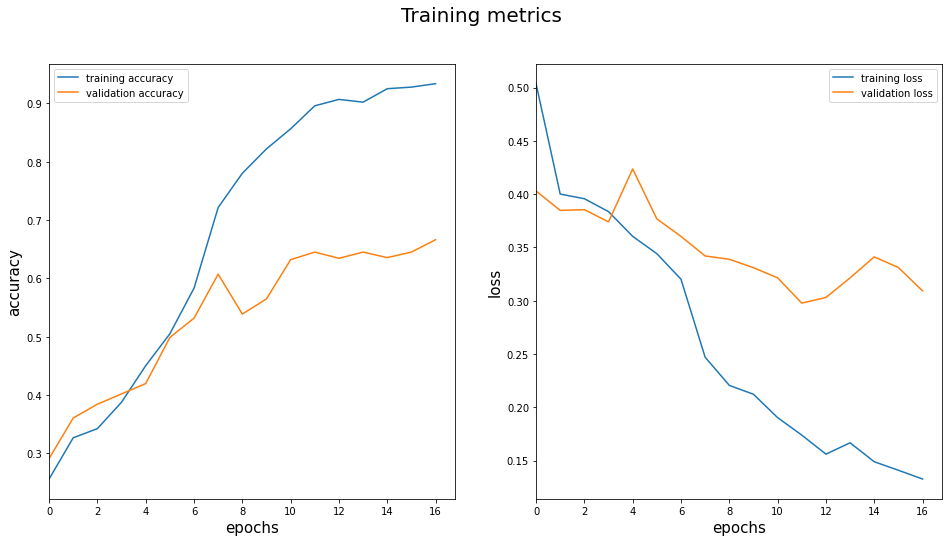

In [124]:
visualise_results(history)

In [125]:
weights_path = 'flowers_capsnet.h5'

In [126]:
model.save_weights(weights_path)

In [134]:
from tensorflow.keras.layers import MaxPooling2D, Flatten

class FlowerCNN(tf.keras.Model):
    def __init__(self, image_dimensions):
        super(FlowerCNN, self).__init__()
        # ---------------------------- Facemask CNN ----------------------------
        # set image dimensions.
        self.image_height, self.image_width, self.image_channels = image_dimensions

        # Facemask dataset has 1 class.
        self.classes = 5

        self.conv1 = Conv2D(32, 7, activation='relu')
        self.maxpool1 = MaxPooling2D()
        self.conv2 = Conv2D(64, 3, padding='same', activation='relu')
        self.maxpool2 = MaxPooling2D()
        self.conv3 = Conv2D(128, 3, padding='same', activation='relu')
        self.maxpool3 = MaxPooling2D()
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.output_layer = Dense(self.classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.output_layer(x)
        return x

In [135]:
from tensorflow.keras.losses import CategoricalCrossentropy

image_dimensions = (flowersDataset.img_height, flowersDataset.img_width, 3)
model = FlowerCNN(image_dimensions)
model.build((batch_size,) + image_dimensions)
model.compile(optimizer=Adam(1e-4), loss=CategoricalCrossentropy(), metrics='accuracy')
model.summary(line_length=137)

Model: "flower_cnn_2"
_________________________________________________________________________________________________________________________________________
Layer (type)                                                 Output Shape                                           Param #              
conv2d_83 (Conv2D)                                           multiple                                               4736                 
_________________________________________________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)                               multiple                                               0                    
_________________________________________________________________________________________________________________________________________
conv2d_84 (Conv2D)                                           multiple                                               18496                
____________

In [136]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# current time
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# create the checkpoint path
checkpoint_path = "checkpoints/flowers_cnn/" + current_time + ".ckpt"

# create logging
log_dir = "logs/flowers_cnn/" + current_time

# create all callbacks
callbacks = [
  EarlyStopping(patience=5, monitor='val_loss'),
  TensorBoard(log_dir=log_dir, profile_batch=0),
  ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
]

In [137]:
epochs = 100
history = model.fit(
    flowersDataset.train_ds, 
    validation_data=flowersDataset.val_ds, 
    batch_size=batch_size,
    epochs=epochs, 
    validation_steps=flowersDataset.val_size,
    steps_per_epoch=flowersDataset.train_size,
    callbacks=callbacks,
    verbose=1)

Epoch 1/100
160/160 [==============================] - ETA: 0s - loss: 1.3114 - accuracy: 0.4383
Epoch 00001: saving model to checkpoints/flowers_cnn\20210101-230039.ckpt
160/160 [==============================] - 4s 22ms/step - loss: 1.3114 - accuracy: 0.4383 - val_loss: 1.1896 - val_accuracy: 0.4929
Epoch 2/100
160/160 [==============================] - ETA: 0s - loss: 1.0463 - accuracy: 0.5797
Epoch 00002: saving model to checkpoints/flowers_cnn\20210101-230039.ckpt
160/160 [==============================] - 3s 22ms/step - loss: 1.0463 - accuracy: 0.5797 - val_loss: 1.0570 - val_accuracy: 0.5896
Epoch 3/100
160/160 [==============================] - ETA: 0s - loss: 0.9383 - accuracy: 0.6363
Epoch 00003: saving model to checkpoints/flowers_cnn\20210101-230039.ckpt
160/160 [==============================] - 3s 21ms/step - loss: 0.9383 - accuracy: 0.6363 - val_loss: 0.9792 - val_accuracy: 0.6262
Epoch 4/100
160/160 [==============================] - ETA: 0s - loss: 0.8377 - accuracy: 0

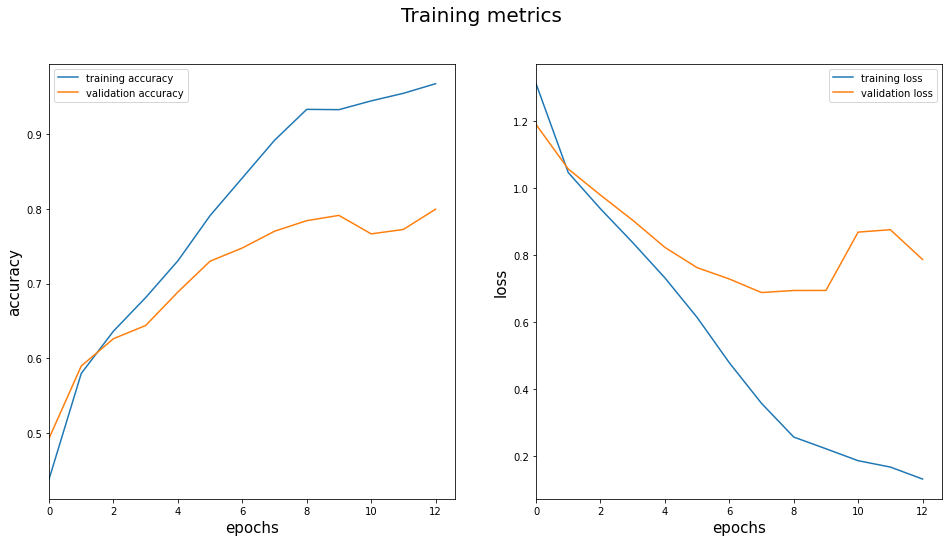

In [138]:
visualise_results(history)